In [ ]:
import os
import sys
import csv
import cv2
import time
import torch
import random
import shutil
import argparse
import numpy as np
from tqdm import tqdm
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from sklearn.model_selection import train_test_split

def is_uppercase(stem):
    """
    Returns True if the filename stem starts with an uppercase letter,
    which we use to mean it's a cat image.
    """
    if not stem:
        return False
    return stem[0].isupper()

def colorize_label(label_img, include_boundary=False):
    """
    Converts a numeric mask (PIL Image in 'L') into an RGB image.
    For include_boundary==False, the expected classes are:
      0: background -> black
      1: cat       -> orange
      2: dog       -> cyan
    For include_boundary==True, we expect an additional class:
      3: boundary  -> white
    """
    arr = np.array(label_img)
    color_arr = np.zeros((arr.shape[0], arr.shape[1], 3), dtype=np.uint8)
    if include_boundary:
        color_map = {
            0: (0,   0,   0),      # background = black
            1: (255, 165, 0),      # cat = orange
            2: (0,   255, 255),    # dog = cyan
            3: (255, 255, 255)     # boundary = white
        }
    else:
        color_map = {
            0: (0, 0, 0),
            1: (255, 165, 0),
            2: (0, 255, 255)
        }
    for class_val, color in color_map.items():
        color_arr[arr == class_val] = color
    return Image.fromarray(color_arr, mode="RGB")

def convert_label_to_three_classes(label_img, is_cat):
    """
    For TrainVal:
    Convert a grayscale label (mode "L") that may contain:
      - 0 for background,
      - 255 for boundary,
      - values in (1..254) for the animal region,
    into a new label with:
      - 0 for background (and boundary merged),
      - 1 for cat (if is_cat True),
      - 2 for dog (if is_cat False).
    """
    arr = np.array(label_img, dtype=np.uint8)
    new_label = np.zeros_like(arr, dtype=np.uint8)
    if is_cat:
        new_label[(arr > 0) & (arr < 255)] = 1
    else:
        new_label[(arr > 0) & (arr < 255)] = 2
    return Image.fromarray(new_label)

def convert_label_test(label_img, is_cat):
    """
    For Test:
    Convert an RGB label image (that contains a boundary) into a numeric mask with 4 classes:
      0 = background (black)
      3 = boundary (white; pixels where R=G=B=255)
      For the remaining animal region, assign:
          1 if is_cat is True (cat),
          2 if is_cat is False (dog).
    """
    arr = np.array(label_img)
    # Create a single-channel mask
    mask = np.zeros(arr.shape[:2], dtype=np.uint8)
    # Background: where pixel is black
    background = (arr[:,:,0] == 0) & (arr[:,:,1] == 0) & (arr[:,:,2] == 0)
    mask[background] = 0
    # Boundary: where pixel is white
    boundary = (arr[:,:,0] == 255) & (arr[:,:,1] == 255) & (arr[:,:,2] == 255)
    mask[boundary] = 3
    # Animal region: everything that is not background or boundary
    animal = ~(background | boundary)
    if is_cat:
        mask[animal] = 1
    else:
        mask[animal] = 2
    return Image.fromarray(mask)

# --------------------------
# Resizing and Padding Classes
# --------------------------

class ResizeWithPadding:
    """For color images. Uses bilinear interpolation."""
    def __init__(self, target_size=512, padding_mode='mean', force_resize=True, resize_dims=(128, 128)):
        self.target_size = target_size
        self.force_resize = force_resize
        self.resize_dims = resize_dims
        assert padding_mode in ['mean', 'reflect', 'hybrid'], "Padding mode must be 'mean', 'reflect', or 'hybrid'"
        self.padding_mode = padding_mode

    def resize_image(self, image):
        h, w = image.shape[:2]
        scale = self.resize_dims[0] / max(h, w)
        new_w, new_h = int(w * scale), int(h * scale)
        return cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    def pad_image(self, image):
        h, w = image.shape[:2]
        target_h, target_w = (self.resize_dims if self.force_resize else (self.target_size, self.target_size))
        delta_w = max(0, target_w - w)
        delta_h = max(0, target_h - h)
        top = delta_h // 2
        bottom = delta_h - top
        left = delta_w // 2
        right = delta_w - left
        if self.padding_mode == 'mean':
            mean_pixel = np.mean(image, axis=(0,1), dtype=int)
            padded_image = cv2.copyMakeBorder(image, top, bottom, left, right,
                                              cv2.BORDER_CONSTANT, value=mean_pixel.tolist())
        elif self.padding_mode == 'reflect':
            padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_REFLECT)
        else:
            reflected = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_REFLECT)
            mean_pixel = np.mean(image, axis=(0,1), dtype=int)
            padded_image = cv2.copyMakeBorder(reflected, top, bottom, left, right,
                                              cv2.BORDER_CONSTANT, value=mean_pixel.tolist())
        return padded_image

    def __call__(self, img):
        arr = np.array(img)
        resized = self.resize_image(arr)
        padded = self.pad_image(resized)
        return Image.fromarray(padded)

class ResizeWithPaddingLabel:
    """For label images. Uses nearest-neighbor interpolation."""
    def __init__(self, target_size=512, force_resize=False, resize_dims=(256, 256)):
        self.target_size = target_size
        self.force_resize = force_resize
        self.resize_dims = resize_dims

    def resize_image(self, image):
        h, w = image.shape[:2]
        scale = self.resize_dims[0] / max(h, w)
        new_w, new_h = int(w*scale), int(h*scale)
        return cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

    def pad_image(self, image):
        h, w = image.shape[:2]
        target_h, target_w = (self.resize_dims if self.force_resize else (self.target_size, self.target_size))
        delta_w = max(0, target_w - w)
        delta_h = max(0, target_h - h)
        top = delta_h // 2
        bottom = delta_h - top
        left = delta_w // 2
        right = delta_w - left
        return cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)

    def __call__(self, label_img):
        arr = np.array(label_img)
        resized = self.resize_image(arr)
        padded = self.pad_image(resized)
        return Image.fromarray(padded)

# --------------------------
# Augmentation Function for Synchronized Transforms
# --------------------------

def elastic_transform_pair(image, label, alpha=34, sigma=4):
    """Apply elastic transformation to both image and label."""
    np_img = np.array(image)
    np_label = np.array(label)
    random_state = np.random.RandomState(None)
    shape = np_img.shape[:2]
    dx = (random_state.rand(*shape) * 2 - 1)
    dy = (random_state.rand(*shape) * 2 - 1)
    dx = cv2.GaussianBlur(dx, (17,17), sigma) * alpha
    dy = cv2.GaussianBlur(dy, (17,17), sigma) * alpha
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    map_x = (x+dx).astype(np.float32)
    map_y = (y+dy).astype(np.float32)
    transformed_img = cv2.remap(np_img, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    transformed_label = cv2.remap(np_label, map_x, map_y, interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT)
    return Image.fromarray(transformed_img), Image.fromarray(transformed_label)

def augment_pair(image, label, size=(256,256), apply_color=True, **params):
    """
    Applies a random subset of augmentations in random order.
    """
    augmentations = []
    augmentations.append((lambda img, lbl: (F.hflip(img), F.hflip(lbl)), params.get("flip_prob",0.5)))
    def rotate_aug(img, lbl):
        angle = random.uniform(-params.get("rotation_angle",5), params.get("rotation_angle",45))
        return F.rotate(img, angle, interpolation=Image.BILINEAR), F.rotate(lbl, angle, interpolation=Image.NEAREST)
    augmentations.append((rotate_aug, params.get("rotation_prob",0.25)))
    def translate_aug(img, lbl):
        max_translate = params.get("translate_factor", 0.05)*size[0]
        tx = int(random.uniform(-max_translate, max_translate))
        ty = int(random.uniform(-max_translate, max_translate))
        return (F.affine(img, angle=0, translate=(tx,ty), scale=1.0, shear=0, interpolation=Image.BILINEAR),
                F.affine(lbl, angle=0, translate=(tx,ty), scale=1.0, shear=0, interpolation=Image.NEAREST))
    augmentations.append((translate_aug, params.get("translate_prob",0.05)))
    def crop_aug(img, lbl):
        i,j,h,w = transforms.RandomResizedCrop.get_params(img, scale=params.get("crop_scale_range",(0.9,1.0)), ratio=params.get("crop_ratio_range",(1.0,1.0)))
        return (F.resized_crop(img, i,j,h,w,size, interpolation=Image.BILINEAR),
                F.resized_crop(lbl, i,j,h,w,size, interpolation=Image.NEAREST))
    augmentations.append((crop_aug, params.get("crop_prob",0.01)))
    def elastic_aug(img, lbl):
        return elastic_transform_pair(img, lbl, alpha=params.get("elastic_alpha",15), sigma=params.get("elastic_sigma",2))
    augmentations.append((elastic_aug, params.get("elastic_prob",0.01)))
    def scaling_aug(img, lbl):
        scale_factor = random.uniform(*params.get("scaling_range",(0.0,0.0)))
        new_size = (int(size[0]*scale_factor), int(size[1]*scale_factor))
        return (F.resize(img, new_size, interpolation=Image.BILINEAR),
                F.resize(lbl, new_size, interpolation=Image.NEAREST))
    augmentations.append((scaling_aug, params.get("scaling_prob",0.0)))
    def color_aug(img, lbl):
        if random.random() < params.get("blur_prob",0.0):
            img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(*params.get("blur_radius_range",(0.5,1.5)))))
        color_jitter = transforms.ColorJitter(**params.get("color_jitter_params",{'brightness':0.2,'contrast':0.2,'saturation':0.2,'hue':0.1}))
        img = color_jitter(img)
        return img, lbl
    augmentations.append((color_aug, params.get("color_prob",0.25)))
    random.shuffle(augmentations)
    for func, prob in augmentations:
        if random.random() < prob:
            image, label = func(image, label)
    image = F.center_crop(image, size)
    label = F.center_crop(label, size)
    return image, label

# --------------------------
# OOP Preprocessor Class
# --------------------------

class Preprocessor:
    def __init__(self, raw_color_path, raw_label_path,
                 proc_color_path, proc_label_path,
                 resize_dim=128, do_augmentation=True,
                 is_train=True, max_images=None, aug_count=10, aug_params=None):
        self.aug_params = aug_params if aug_params is not None else {}
        self.raw_color_path = Path(raw_color_path)
        self.raw_label_path = Path(raw_label_path)
        self.proc_color_path = Path(proc_color_path)
        self.proc_label_path = Path(proc_label_path)
        self.resize_dim = resize_dim
        self.do_augmentation = do_augmentation and is_train
        self.is_train = is_train  # True for TrainVal, False for Test
        self.max_images = max_images
        self.aug_count = aug_count
        self.proc_color_path.mkdir(parents=True, exist_ok=True)
        self.proc_label_path.mkdir(parents=True, exist_ok=True)
        self.transform_img = ResizeWithPadding(target_size=224, padding_mode='mean',
                                              force_resize=True, resize_dims=(resize_dim, resize_dim))
        self.transform_label = ResizeWithPaddingLabel(target_size=224, force_resize=True,
                                                      resize_dims=(resize_dim, resize_dim))

    def process(self):
        image_extensions = (".jpg", ".jpeg", ".png")
        image_files = [f for f in self.raw_color_path.rglob("*") if f.suffix.lower() in image_extensions]
        if self.max_images is not None:
            image_files = image_files[:self.max_images]
        if not image_files:
            print("❌ No images found in", self.raw_color_path)
            return
        for img_file in image_files:
            label_file = self.raw_label_path / f"{img_file.stem}.png"
            if not label_file.exists():
                print(f"⚠️  Label for {img_file.name} not found, skipping.")
                continue

            # For TrainVal, load label in grayscale; for Test, load in RGB (to preserve boundaries)
            if self.is_train:
                label = Image.open(label_file).convert("L")
            else:
                label = Image.open(label_file).convert("RGB")
            img = Image.open(img_file).convert("RGB")
            proc_img = self.transform_img(img)
            proc_label = self.transform_label(label)
            cat_or_dog = is_uppercase(img_file.stem)  # True => cat, False => dog

            if self.is_train:
                # Merge boundary with background and set animal region accordingly.
                numeric_label = convert_label_to_three_classes(proc_label, cat_or_dog)
                colorized_label = colorize_label(numeric_label)
            else:
                # Test: Convert RGB label to numeric with boundary preserved (0,1,2,3),
                # then colorize using the same mapping (cat always orange, dog always cyan, boundary white).
                numeric_label = convert_label_test(proc_label, cat_or_dog)
                colorized_label = colorize_label(numeric_label, include_boundary=True)

            if cat_or_dog:
                proc_img.save(self.proc_color_path / f"cat_{img_file.name}")
                colorized_label.save(self.proc_label_path / f"cat_{label_file.name}")
                print(f"Processed (cat) {img_file.name}")
            else:
                proc_img.save(self.proc_color_path / f"dog_{img_file.name}")
                colorized_label.save(self.proc_label_path / f"dog_{label_file.name}")
                print(f"Processed (dog) {img_file.name}")

            if self.is_train and self.do_augmentation:
                for i in range(self.aug_count):
                    aug_img, aug_label = augment_pair(proc_img, numeric_label,
                                                      size=(self.resize_dim, self.resize_dim),
                                                      **self.aug_params)
                    colorized_aug_label = colorize_label(aug_label)
                    if cat_or_dog:
                        aug_img.save(self.proc_color_path / f"cat_{img_file.stem}_aug_{i}{img_file.suffix}")
                        colorized_aug_label.save(self.proc_label_path / f"cat_{label_file.stem}_aug_{i}{label_file.suffix}")
                    else:
                        aug_img.save(self.proc_color_path / f"dog_{img_file.stem}_aug_{i}{img_file.suffix}")
                        colorized_aug_label.save(self.proc_label_path / f"dog_{label_file.stem}_aug_{i}{label_file.suffix}")
                    print(f"Augmented {img_file.name} -> aug {i}")

# --------------------------
# Command Line Interface
# --------------------------

if __name__ == "__main__":
    parser = argparse.ArgumentParser(
        description="Preprocess train/test images with labels/masks using relative paths."
    )
    parser.add_argument("--raw_color", type=str, required=True, default='raw/TrainVal/color')
    parser.add_argument("--raw_label", type=str, required=True, default='raw/TrainVal/label')
    parser.add_argument("--proc_color", type=str, required=True, default='Dataset/processed/TrainVal/color')
    parser.add_argument("--proc_label", type=str, required=True, default='Dataset/processed/TrainVal/label')
    parser.add_argument("--resize_dim", type=int, default=128)
    parser.add_argument("--no_augment", action="store_true")
    parser.add_argument("--max_images", type=int, default=None)
    parser.add_argument("--aug_count", type=int, default=10)
    parser.add_argument("--set_type", type=str, choices=["TrainVal", "Test"], default="TrainVal")
    parser.add_argument("--flip_prob", type=float, default=0.5)
    parser.add_argument("--rotation_angle", type=float, default=5)
    parser.add_argument("--translate_factor", type=float, default=0.05)
    parser.add_argument("--crop_scale_min", type=float, default=0.9)
    parser.add_argument("--crop_scale_max", type=float, default=1.0)
    parser.add_argument("--crop_ratio_min", type=float, default=1.0)
    parser.add_argument("--crop_ratio_max", type=float, default=1.0)
    parser.add_argument("--elastic_alpha", type=float, default=15)
    parser.add_argument("--elastic_sigma", type=float, default=2)
    parser.add_argument("--scaling_min", type=float, default=0.0)
    parser.add_argument("--scaling_max", type=float, default=0.0)
    parser.add_argument("--blur_prob", type=float, default=0.3)
    parser.add_argument("--blur_radius_min", type=float, default=0.5)
    parser.add_argument("--blur_radius_max", type=float, default=1.5)
    parser.add_argument("--color_jitter_brightness", type=float, default=0.2)
    parser.add_argument("--color_jitter_contrast", type=float, default=0.2)
    parser.add_argument("--color_jitter_saturation", type=float, default=0.2)
    parser.add_argument("--color_jitter_hue", type=float, default=0.1)

    # Example invocation (change as needed)
    sys.argv = [
        'preprocessing.py',
        '--raw_color', './Datasetraw/Test/color',
        '--raw_label', './Dataset/raw/Test/label',
        '--proc_color', './Dataset/processed/Test/color',
        '--proc_label', './Dataset/processed/Test/label',
        '--resize_dim', '128',
        '--no_augment',
        '--set_type', 'Test'
    ]

    '''sys.argv = ['preprocessing.py',
                '--raw_color', './Dataset/raw/TrainVal/color',
                '--raw_label', './Dataset/raw/TrainVal/label',
                '--proc_color', './Dataset/processed/TrainVal/color',
                '--proc_label', './Dataset/processed/TrainVal/label',
                '--resize_dim', '128',
                '--aug_count', '10',
                '--set_type', 'TrainVal',
                '--translate_factor', '0.02',
                '--elastic_alpha', '0.0',
                '--elastic_sigma', '0.05',
                '--blur_radius_min', '0.0',
                '--blur_radius_max', '0.05']'''

    args = parser.parse_args()

    if args.set_type == "TrainVal":
        raw_color = Path("./raw/TrainVal/color")
        raw_label = Path("./raw/TrainVal/label")
        proc_color = Path("./Dataset/processed/TrainVal/color")
        proc_label = Path("./Dataset/processed/TrainVal/label")
        is_train = True
    else:
        raw_color = Path("./raw/Test/color")
        raw_label = Path("./raw/Test/label")
        proc_color = Path("./Dataset/processed/Test/color")
        proc_label = Path("./Dataset/processed/Test/label")
        is_train = False

    aug_params = {
        "flip_prob": args.flip_prob,
        "rotation_angle": args.rotation_angle,
        "rotation_prob": 0.25,
        "translate_factor": args.translate_factor,
        "translate_prob": 0.05,
        "crop_scale_range": (args.crop_scale_min, args.crop_scale_max),
        "crop_ratio_range": (args.crop_ratio_min, args.crop_ratio_max),
        "crop_prob": 0.01,
        "elastic_alpha": args.elastic_alpha,
        "elastic_sigma": args.elastic_sigma,
        "elastic_prob": 0.01,
        "scaling_range": (0.8, 1.2),
        "scaling_prob": 0.05,
        "blur_prob": args.blur_prob,
        "blur_radius_range": (args.blur_radius_min, args.blur_radius_max),
        "color_jitter_params": {
            "brightness": args.color_jitter_brightness,
            "contrast": args.color_jitter_contrast,
            "saturation": args.color_jitter_saturation,
            "hue": args.color_jitter_hue,
        },
        "color_prob": 1.0
    }

    preprocessor = Preprocessor(
        raw_color, raw_label,
        proc_color, proc_label,
        resize_dim=args.resize_dim,
        do_augmentation=not args.no_augment,
        is_train=is_train,
        max_images=args.max_images,
        aug_count=args.aug_count,
        aug_params=aug_params
    )

    preprocessor.process()

Processed (cat) Egyptian_Mau_167.jpg
Processed (dog) pug_52.jpg
Processed (cat) Siamese_53.jpg
Processed (dog) leonberger_6.jpg
Processed (cat) Siamese_47.jpg
Processed (cat) Abyssinian_225.jpg
Processed (dog) miniature_pinscher_200.jpg
Processed (dog) wheaten_terrier_49.jpg
Processed (dog) pug_46.jpg
Processed (dog) shiba_inu_43.jpg
Processed (dog) wheaten_terrier_61.jpg
Processed (dog) saint_bernard_2.jpg
Processed (cat) Abyssinian_219.jpg
Processed (dog) shiba_inu_57.jpg
Processed (dog) wheaten_terrier_75.jpg
Processed (dog) pug_91.jpg
Processed (cat) Siamese_90.jpg
Processed (dog) pomeranian_59.jpg
Processed (cat) Sphynx_241.jpg
Processed (cat) Egyptian_Mau_23.jpg
Processed (cat) Siamese_84.jpg
Processed (dog) pug_85.jpg
Processed (cat) British_Shorthair_38.jpg
Processed (cat) Birman_2.jpg
Processed (cat) Bombay_213.jpg
Processed (cat) Egyptian_Mau_198.jpg
Processed (dog) shiba_inu_80.jpg
Processed (dog) pomeranian_65.jpg
Processed (cat) Birman_198.jpg
Processed (dog) pomeranian_71

In [4]:
import torch
from torch.utils.data import Dataset
from pathlib import Path
import numpy as np
from PIL import Image
from torchvision import transforms

class SegmentationDataset(Dataset):
    """
    A simple dataset for image segmentation.

    Assumes:
      - root_dir/color: contains the color (RGB) images.
      - root_dir/label: contains the corresponding label images (in color).
      - Each label image has the same stem as its corresponding color image,
        and uses a .png extension.

    Optional transforms:
      - transform_img: transformation to apply to color images (e.g. normalization).
      - transform_label: transformation to apply to label images (less common).

    Returns a tuple (image, label) where:
      - image is a Tensor of shape (C, H, W).
      - label is a Tensor of shape (H, W) containing integer class indices:
         0 = background
         1 = cat
         2 = dog
    """
    def __init__(self, root_dir, transform_img=None, transform_label=None):
        self.root_dir = Path(root_dir)
        self.color_dir = self.root_dir / "color"
        self.label_dir = self.root_dir / "label"
        self.transform_img = transform_img
        self.transform_label = transform_label

        # Gather all image files from the color directory.
        self.image_files = sorted([
            f for f in self.color_dir.iterdir()
            if f.is_file() and f.suffix.lower() in [".png", ".jpg", ".jpeg"]
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # 1) Load color image in RGB
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")

        # 2) Build corresponding label path, open in RGB as well
        label_path = self.label_dir / (img_path.stem + ".png")
        label_img = Image.open(label_path).convert("RGB")  # color-coded label

        # 3) Optional transform on the color image
        if self.transform_img:
            image = self.transform_img(image)
        else:
            image = transforms.ToTensor()(image)

        # 4) Convert the color-coded label to a NumPy array
        label_np = np.array(label_img, dtype=np.uint8)  # shape = (H, W, 3)

        # Create an empty single-channel array to store class indices
        #   0 = background
        #   1 = cat (orange = [255,165,0])
        #   2 = dog (cyan = [0,255,255])
        label_new = np.zeros((label_np.shape[0], label_np.shape[1]), dtype=np.int64)

        # Identify background = black
        background_mask = (
            (label_np[..., 0] == 0) &
            (label_np[..., 1] == 0) &
            (label_np[..., 2] == 0)
        )
        label_new[background_mask] = 0

        # Identify cat = orange
        cat_mask = (
            (label_np[..., 0] == 255) &
            (label_np[..., 1] == 165) &
            (label_np[..., 2] == 0)
        )
        label_new[cat_mask] = 1

        # Identify dog = cyan
        dog_mask = (
            (label_np[..., 0] == 0) &
            (label_np[..., 1] == 255) &
            (label_np[..., 2] == 255)
        )
        label_new[dog_mask] = 2

        # Convert to torch tensor
        label_tensor = torch.from_numpy(label_new).long()

        # 5) Optional transform on the label (usually None)
        if self.transform_label:
            label_tensor = self.transform_label(label_tensor)

        return image, label_tensor

In [5]:
#############################################
#             Patch-based dataset           #
#############################################

class PatchBasedDataset(Dataset):
    def __init__(self, root_dir, patch_size=128, transform_img=None, transform_label=None):
        """
        root_dir: Path to e.g. /content/processed/TrainVal
        patch_size: size of the patch to randomly crop
        transform_img: transformations to apply to the color image
        transform_label: transformations to apply to the label (optional)
        """
        self.base_dataset = SegmentationDataset(root_dir, transform_img, transform_label)
        self.patch_size = patch_size

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        # Retrieve the full image and mask from the base dataset
        image, mask = self.base_dataset[idx]  # image: (C, H, W), mask: (H, W)

        # Convert to PIL for random crop
        # but do NOT use transforms.ToTensor() on the mask again
        to_pil_img = transforms.ToPILImage()

        pil_image = to_pil_img(image)  # This will produce a PIL image in RGB
        # For the mask, ensure it's uint8 so that 0..255 remains intact
        pil_mask = Image.fromarray(mask.cpu().numpy().astype(np.uint8), mode="L")

        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(
            pil_image, output_size=(self.patch_size, self.patch_size)
        )
        pil_image_patch = transforms.functional.crop(pil_image, i, j, h, w)
        pil_mask_patch = transforms.functional.crop(pil_mask, i, j, h, w)

        # Convert the cropped image back to a tensor (with normalization if needed)
        # e.g. transforms.ToTensor() or your transform_img pipeline
        # If your base_dataset already has transform_img, you can just do:
        image_patch = transforms.ToTensor()(pil_image_patch)

        # Convert the mask patch to a NumPy array to preserve integer classes
        mask_patch_np = np.array(pil_mask_patch, dtype=np.int64)

        # Convert to torch tensor of type long
        mask_patch = torch.from_numpy(mask_patch_np).long()

        return image_patch, mask_patch

In [6]:
#############################################
#           Debug utils Definition          #
#############################################

def visualize_samples(dataset, num_samples=3):
    """
    Prints and plots a few samples + labels from your dataset.
    """
    for i in range(num_samples):
        img, mask = dataset[i]  # Each dataset[i] = (img, mask)
        print(f"Sample {i} - Image shape: {img.shape}, Mask shape: {mask.shape}")
        fig, ax = plt.subplots(1, 2, figsize=(8,4))
        ax[0].imshow(img.permute(1, 2, 0))
        ax[1].imshow(mask, cmap='gray')
        ax[0].set_title("Image")
        ax[1].set_title("Mask")
        plt.show()

def visualize_predictions(model, dataloader, device, num_samples=3):
    model.eval()
    samples = []
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu()
            samples.append((images.cpu(), masks, preds))
            if len(samples) >= num_samples:
                break
    for idx, (img, mask, pred) in enumerate(samples):
        print(f"Predicted sample {idx}")
        fig, ax = plt.subplots(1, 3, figsize=(12,4))
        ax[0].imshow(img[0].permute(1,2,0))
        ax[1].imshow(mask[0], cmap='gray')
        ax[2].imshow(pred[0], cmap='gray')
        ax[0].set_title("Input Image")
        ax[1].set_title("Ground Truth")
        ax[2].set_title("Prediction")
        plt.show()

def get_weighted_ce_loss(dataset, num_classes):
    """
    Example of creating a class-weighted CrossEntropyLoss
    if you have an imbalanced dataset.
    """
    # Compute simple frequency-based weights (just an example)
    # Real usage: count the number of pixels per class across the dataset.
    # Here we use a placeholder uniform distribution
    class_counts = [100, 200, 300]  # example
    total = sum(class_counts)
    weights = [total / c for c in class_counts]
    weights_tensor = torch.tensor(weights, dtype=torch.float)
    return torch.nn.CrossEntropyLoss(weight=weights_tensor)

#############################################
#           Compute class weights           #
#############################################

def compute_class_weights(dataset, num_classes):
    counts = np.zeros(num_classes, dtype=np.float64)
    for _, mask in dataset:
        if not isinstance(mask, np.ndarray):
            mask = np.array(mask)
        for c in range(num_classes):
            counts[c] += np.sum(mask == c)
    total_pixels = counts.sum()
    weights = total_pixels / (num_classes * counts + 1e-6)
    return torch.tensor(weights, dtype=torch.float32)

def adjust_learning_rate(optimizer, new_lr):
    """
    Set a new learning rate to see if predictions shift.
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

In [8]:
import torch.nn as nn

#############################################
#          Loss Functions & Metrics         #
#############################################

def compute_dice(pred, target, num_classes, smooth=1e-6):
    """
    Computes the Dice coefficient for each class.
    Returns (avg_dice, dice_tensor) where:
      - dice_tensor is a tensor of shape [num_classes] with the Dice coefficient per class.
      - avg_dice is the mean (ignoring nan values).
    """
    dice_scores = []
    for cls in range(num_classes):
        pred_c = (pred == cls).float()
        target_c = (target == cls).float()
        intersection = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum()
        if union == 0:
            dice_scores.append(float('nan'))
        else:
            dice_scores.append((2 * intersection + smooth) / (union + smooth))
    dice_tensor = torch.tensor(dice_scores, dtype=torch.float32)
    avg_dice = torch.nanmean(dice_tensor).item()
    return avg_dice, dice_tensor

def compute_iou(pred, target, num_classes, smooth=1e-6):
    """
    Computes IoU for each class.
    Both pred and target are torch tensors of shape [N, H, W].
    Returns a tensor of shape [num_classes] with IoU per class.
    """
    ious = []
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()
        if union == 0:
            ious.append(float('nan'))  # undefined IoU if no pixels of this class
        else:
            ious.append((intersection + smooth) / (union + smooth))
    return torch.tensor(ious, dtype=torch.float32)

def dice_loss(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    num_classes = pred.shape[1]
    target_one_hot = F.one_hot(target.contiguous(), num_classes).permute(0, 3, 1, 2).contiguous().float()
    intersection = (pred * target_one_hot).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

class HybridLoss(nn.Module):
    def __init__(self, weight=0.5, ce_weight=None):
        super().__init__()
        self.weight = weight
        self.ce_loss = nn.CrossEntropyLoss(weight=ce_weight) if ce_weight is not None else nn.CrossEntropyLoss()
    def forward(self, pred, target):
        ce = self.ce_loss(pred, target)
        d  = dice_loss(pred, target)
        return self.weight * ce + (1 - self.weight) * d

def pixel_accuracy(output, target):
    _, preds = torch.max(output, dim=1)
    correct = (preds == target).float().sum()
    return correct / torch.numel(target)

#############################################
#                Save metrics               #
#############################################

import csv
def save_metrics(metrics, test_loss, test_acc, test_iou, filepath):
    fieldnames = [
        'epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc',
        'val_iou_avg', 'val_iou_class0', 'val_iou_class1', 'val_iou_class2',
        'val_dice_avg', 'val_dice_class0', 'val_dice_class1', 'val_dice_class2',
        'test_loss', 'test_acc', 'test_iou'
    ]
    # Write (or overwrite) the CSV file with current metrics.
    with open(filepath, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for m in metrics:
            writer.writerow({
                'epoch': m.get('epoch', ''),
                'train_loss': m.get('train_loss', ''),
                'train_acc': m.get('train_acc', ''),
                'val_loss': m.get('val_loss', ''),
                'val_acc': m.get('val_acc', ''),
                'val_iou_avg': m.get('val_iou_avg', ''),
                'val_iou_class0': m.get('val_iou_class0', ''),
                'val_iou_class1': m.get('val_iou_class1', ''),
                'val_iou_class2': m.get('val_iou_class2', ''),
                'val_dice_avg': m.get('val_dice_avg', ''),
                'val_dice_class0': m.get('val_dice_class0', ''),
                'val_dice_class1': m.get('val_dice_class1', ''),
                'val_dice_class2': m.get('val_dice_class2', ''),
                'test_loss': '',
                'test_acc': '',
                'test_iou': ''
            })
        # Write test metrics in a final row if available.
        writer.writerow({
            'epoch': 'test',
            'train_loss': '',
            'train_acc': '',
            'val_loss': '',
            'val_acc': '',
            'val_iou_avg': '',
            'val_iou_class0': '',
            'val_iou_class1': '',
            'val_iou_class2': '',
            'val_dice_avg': '',
            'val_dice_class0': '',
            'val_dice_class1': '',
            'val_dice_class2': '',
            'test_loss': test_loss,
            'test_acc': test_acc,
            'test_iou': test_iou
        })

In [9]:
#############################################
#          Improved Deep UNet Model         #
#           for 128x128 Images              #
#############################################

class DoubleConv(nn.Module):
    """
    Two consecutive conv layers, each with BatchNorm, Dropout2d and LeakyReLU activation.
    """
    def __init__(self, in_channels, out_channels, dropout_prob=0.25):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(dropout_prob),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """
    Downscaling with maxpool followed by a DoubleConv block.
    """
    def __init__(self, in_channels, out_channels, dropout_prob=0.25):
        super(Down, self).__init__()
        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels, dropout_prob)
        )

    def forward(self, x):
        return self.down(x)

class Up(nn.Module):
    """
    Upscaling (using bilinear interpolation) then a DoubleConv block.
    """
    def __init__(self, x1_channels, x2_channels, out_channels, bilinear=True, dropout_prob=0.25):
        super(Up, self).__init__()
        self.bilinear = bilinear
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(x1_channels, x1_channels, kernel_size=2, stride=2)
        total_in_channels = x1_channels + x2_channels
        self.conv = DoubleConv(total_in_channels, out_channels, dropout_prob)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    """
    Final 1x1 convolution to map to the desired number of classes.
    """
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    """
    Deep UNet for 128x128 input images with four downsampling steps.
    """
    def __init__(self, n_channels, n_classes, bilinear=True, base_channels=64, dropout_prob=0.25, apply_softmax=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.apply_softmax = apply_softmax

        self.inc   = DoubleConv(n_channels, base_channels, dropout_prob)
        self.down1 = Down(base_channels, base_channels * 2, dropout_prob)
        self.down2 = Down(base_channels * 2, base_channels * 4, dropout_prob)
        self.down3 = Down(base_channels * 4, base_channels * 8, dropout_prob)
        self.down4 = Down(base_channels * 8, base_channels * 16, dropout_prob)

        self.up1 = Up(x1_channels=base_channels * 16, x2_channels=base_channels * 8,
                      out_channels=(base_channels * 8) // 2, bilinear=bilinear, dropout_prob=dropout_prob)
        self.up2 = Up(x1_channels=(base_channels * 8) // 2, x2_channels=base_channels * 4,
                      out_channels=(base_channels * 4) // 2, bilinear=bilinear, dropout_prob=dropout_prob)
        self.up3 = Up(x1_channels=(base_channels * 4) // 2, x2_channels=base_channels * 2,
                      out_channels=(base_channels * 2) // 2, bilinear=bilinear, dropout_prob=dropout_prob)
        self.up4 = Up(x1_channels=(base_channels * 2) // 2, x2_channels=base_channels,
                      out_channels=base_channels, bilinear=bilinear, dropout_prob=dropout_prob)

        self.outc = OutConv(base_channels, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        if self.apply_softmax:
            return F.softmax(logits, dim=1)
        else:
            return logits

In [ ]:
#############################################
#                  Training                 #
#############################################


import os
import sys
import csv
import cv2
import time
import torch
import random
import shutil
import argparse
import numpy as np
from tqdm import tqdm
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from sklearn.model_selection import train_test_split

# Enable cuDNN benchmark for fixed input sizes (e.g., 128x128)
torch.backends.cudnn.benchmark = True

#############################################
#           Training & Validation           #
#############################################

def train_epoch(model, dataloader, optimizer, device):
    model.train()
    running_loss, running_acc = 0.0, 0.0
    total_batches = len(dataloader)
    start_epoch = time.perf_counter()

    for batch_idx, (images, masks) in enumerate(dataloader):
        iter_start = time.perf_counter()
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        iter_end = time.perf_counter()
        iter_time = iter_end - iter_start

        running_loss += loss.item() * images.size(0)
        running_acc += pixel_accuracy(outputs, masks).item() * images.size(0)

        elapsed_epoch = time.perf_counter() - start_epoch
        completed_iters = batch_idx + 1
        remaining_iters = total_batches - completed_iters
        avg_iter_time = elapsed_epoch / completed_iters
        eta_epoch = remaining_iters * avg_iter_time

        percent = (completed_iters / total_batches) * 100
        print(f"\rEpoch Progress: {percent:.0f}% | Loss: {loss.item():.4f} | Iter time: {iter_time:.4f}s | ETA: {eta_epoch:.2f}s", end="")

    end_epoch = time.perf_counter()
    epoch_time = end_epoch - start_epoch
    print(f"\nEpoch completed in {epoch_time:.2f} seconds.")
    return running_loss / len(dataloader.dataset), running_acc / len(dataloader.dataset)

def test_model(model_path, test_dataset, batch_size=8, num_classes=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global criterion
    criterion = torch.nn.CrossEntropyLoss()
    criterion = criterion.to(device)

    model = UNet(n_channels=3, n_classes=3).to(device)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    running_loss, running_acc = 0.0, 0.0
    all_preds, all_masks = [], []
    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Testing"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item() * images.size(0)
            running_acc += pixel_accuracy(outputs, masks).item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu())
            all_masks.append(masks.cpu())
    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_acc / len(test_loader.dataset)
    all_preds = torch.cat(all_preds, dim=0)
    all_masks = torch.cat(all_masks, dim=0)
    iou_tensor = compute_iou(all_preds, all_masks, num_classes)
    iou_tensor = torch.as_tensor(iou_tensor, dtype=torch.float32)
    test_iou = torch.nanmean(iou_tensor).item()
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test IoU: {test_iou:.4f}")
    return test_loss, test_acc, test_iou

def validate_epoch(model, dataloader, device, num_classes=3):
    model.eval()
    running_loss, running_acc = 0.0, 0.0
    all_preds = []
    all_masks = []
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item() * images.size(0)
            running_acc += pixel_accuracy(outputs, masks).item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu())
            all_masks.append(masks.cpu())
    all_preds = torch.cat(all_preds, dim=0)
    all_masks = torch.cat(all_masks, dim=0)
    
    # Compute per-class IoU and average IoU.
    iou_tensor = compute_iou(all_preds, all_masks, num_classes)
    avg_iou = torch.nanmean(iou_tensor).item()
    
    # Compute per-class Dice and average Dice.
    avg_dice, dice_tensor = compute_dice(all_preds, all_masks, num_classes)
    
    val_loss = running_loss / len(dataloader.dataset)
    val_acc = running_acc / len(dataloader.dataset)
    
    print(f"\nValidation Loss: {val_loss:.4f}, Pixel Acc: {val_acc:.4f}")
    print(f"Validation IoU per class: {iou_tensor.numpy()} (Avg: {avg_iou:.4f})")
    print(f"Validation Dice per class: {dice_tensor.numpy()} (Avg: {avg_dice:.4f})")
    
    return val_loss, val_acc, avg_iou, iou_tensor, avg_dice, dice_tensor

#############################################
#            Training Pipeline              #
#############################################

def train_real_unet(epochs=100, batch_size=8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using {device} device")
    transform_img = transforms.Compose([transforms.ToTensor()])
    transform_label = None
    dataset = PatchBasedDataset(
        root_dir="/content/Dataset/processed/TrainVal",
        patch_size=128,
        transform_img=transform_img,
        transform_label=transform_label
    )
    print(f"Found {len(dataset)} training images.")
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
    train_set = Subset(dataset, train_idx)
    val_set = Subset(dataset, val_idx)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size)

    # Compute class weights from the training set.
    class_weights = compute_class_weights(train_set, num_classes=3)
    print("Computed class weights:", class_weights)

    global criterion
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    criterion = criterion.to(device)

    model = UNet(n_channels=3, n_classes=3).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    best_val_loss = float('inf')
    best_model_path = "unet_best_v3.pth"
    metrics = []
    patience = 30
    patience_counter = 0

    overall_start = time.perf_counter()
    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
        # Get all validation metrics.
        val_loss, val_acc, avg_iou, iou_tensor, avg_dice, dice_tensor = validate_epoch(model, val_loader, device, num_classes=3)
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"Val IoU Avg: {avg_iou:.4f}, IoU per class: {iou_tensor.numpy()}")
        print(f"Val Dice Avg: {avg_dice:.4f}, Dice per class: {dice_tensor.numpy()}")

        # Append metrics for the epoch.
        metrics.append({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_iou_avg': avg_iou,
            'val_iou_class0': iou_tensor[0].item(),
            'val_iou_class1': iou_tensor[1].item(),
            'val_iou_class2': iou_tensor[2].item(),
            'val_dice_avg': avg_dice,
            'val_dice_class0': dice_tensor[0].item(),
            'val_dice_class1': dice_tensor[1].item(),
            'val_dice_class2': dice_tensor[2].item()
        })

        # Save current metrics to CSV at the end of this epoch.
        save_metrics(metrics, test_loss="", test_acc="", test_iou="", filepath="/content/drive/MyDrive/training_metrics.csv")

        # Early stopping: if validation loss improves, save model and reset counter.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
            print("Validation loss improved, model saved.")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epoch(s).")
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

        # Estimate remaining training time.
        elapsed_training = time.perf_counter() - overall_start
        avg_epoch_time = elapsed_training / epoch
        remaining_epochs = epochs - epoch
        eta_training = remaining_epochs * avg_epoch_time
        print(f"Estimated training time remaining: {eta_training:.2f}s")
        scheduler.step()

        # ---------------------------
        # Visualize one validation sample.
        sample = random.choice(val_set)
        sample_img, sample_mask = sample
        with torch.no_grad():
            sample_img_tensor = sample_img.unsqueeze(0).to(device)
            output = model(sample_img_tensor)
            pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()
        sample_img_np = sample_img.cpu().permute(1, 2, 0).numpy()
        sample_mask_np = sample_mask.cpu().numpy()
        plt.figure(figsize=(12, 4))
        plt.subplot(1,3,1)
        plt.imshow(sample_img_np)
        plt.title(f"Epoch {epoch} Input")
        plt.subplot(1,3,2)
        plt.imshow(sample_mask_np, cmap='gray', vmin=0, vmax=2)
        plt.title("Ground Truth")
        plt.subplot(1,3,3)
        plt.imshow(pred, cmap='gray', vmin=0, vmax=2)
        plt.title("Prediction")
        plt.suptitle(f"Epoch {epoch} Sample Visualization")
        plt.show()
        print("GT unique:", np.unique(sample_mask_np))
        print("Pred unique:", np.unique(pred))
        # ---------------------------
    # After training, you can run your test evaluation and then finally update the CSV with test metrics.
    # (Test evaluation code remains as in your original pipeline.)
    return best_model_path, metrics

def main():
    parser = argparse.ArgumentParser(description="Train UNet Model")
    parser.add_argument("--epochs", type=int, default=100, help="Number of training epochs.")
    parser.add_argument("--batch_size", type=int, default=8, help="Batch size for training.")
    sys.argv = ['train_real_unet.py',
                '--epochs', '100',
                '--batch_size', '16']
    args = parser.parse_args()

    best_model_path, metrics = train_real_unet(epochs=args.epochs, batch_size=args.batch_size)
    transform_img = transforms.Compose([transforms.ToTensor()])
    transform_label = None
    print('Loading test dataset...')
    test_dataset = SegmentationDataset(root_dir="/content/processed/Test",
                                         transform_img=transform_img,
                                         transform_label=transform_label)
    print('Test dataset loaded.')
    test_loss, test_acc, test_iou = test_model(best_model_path, test_dataset, batch_size=args.batch_size)
    save_metrics(metrics, test_loss, test_acc, test_iou, "/content/drive/MyDrive/training_metrics.csv")
    print("Training complete. Metrics saved to training_metrics.csv")

if __name__ == "__main__":
    main()

In [15]:
import glob
import os

test_image_dir = "./Dataset/processed/Test/color"
test_mask_dir = "./Dataset/processed/Test/label"

# Collect all image paths (adjust extensions as needed, e.g. *.jpg or *.png)
test_image_paths = sorted(glob.glob(os.path.join(test_image_dir, "*.jpg")))
print(test_image_paths)

['./Dataset/processed/Test/color/cat_Abyssinian_2.jpg', './Dataset/processed/Test/color/cat_Abyssinian_20.jpg', './Dataset/processed/Test/color/cat_Abyssinian_201.jpg', './Dataset/processed/Test/color/cat_Abyssinian_202.jpg', './Dataset/processed/Test/color/cat_Abyssinian_204.jpg', './Dataset/processed/Test/color/cat_Abyssinian_205.jpg', './Dataset/processed/Test/color/cat_Abyssinian_206.jpg', './Dataset/processed/Test/color/cat_Abyssinian_207.jpg', './Dataset/processed/Test/color/cat_Abyssinian_21.jpg', './Dataset/processed/Test/color/cat_Abyssinian_210.jpg', './Dataset/processed/Test/color/cat_Abyssinian_212.jpg', './Dataset/processed/Test/color/cat_Abyssinian_213.jpg', './Dataset/processed/Test/color/cat_Abyssinian_215.jpg', './Dataset/processed/Test/color/cat_Abyssinian_216.jpg', './Dataset/processed/Test/color/cat_Abyssinian_217.jpg', './Dataset/processed/Test/color/cat_Abyssinian_219.jpg', './Dataset/processed/Test/color/cat_Abyssinian_22.jpg', './Dataset/processed/Test/color/cat

Using mps device
Test Loss: 0.3614
Test Pixel Accuracy (ignoring boundary): 0.9349
Test IoU per class: [0.93228346 0.7003681  0.7257312 ], Average IoU: 0.7861
Test Dice per class: [0.96495515 0.8237841  0.84107095], Average Dice: 0.8766


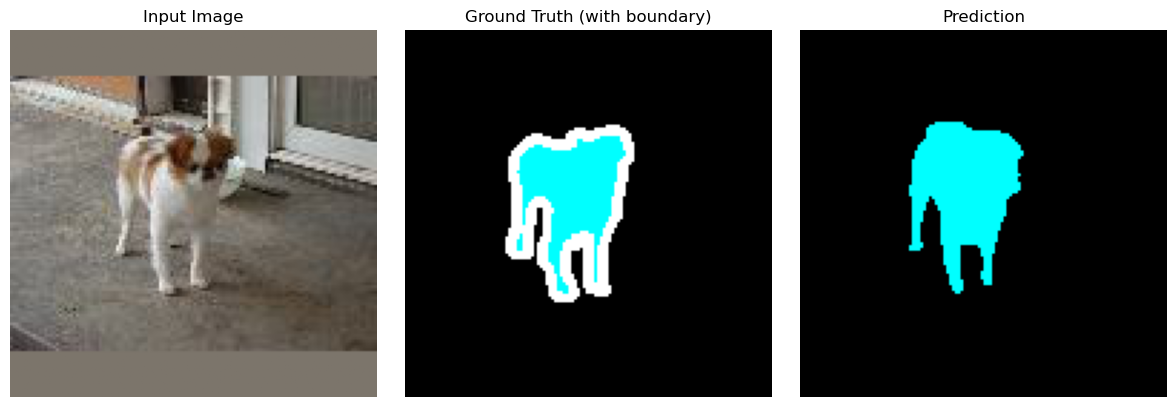

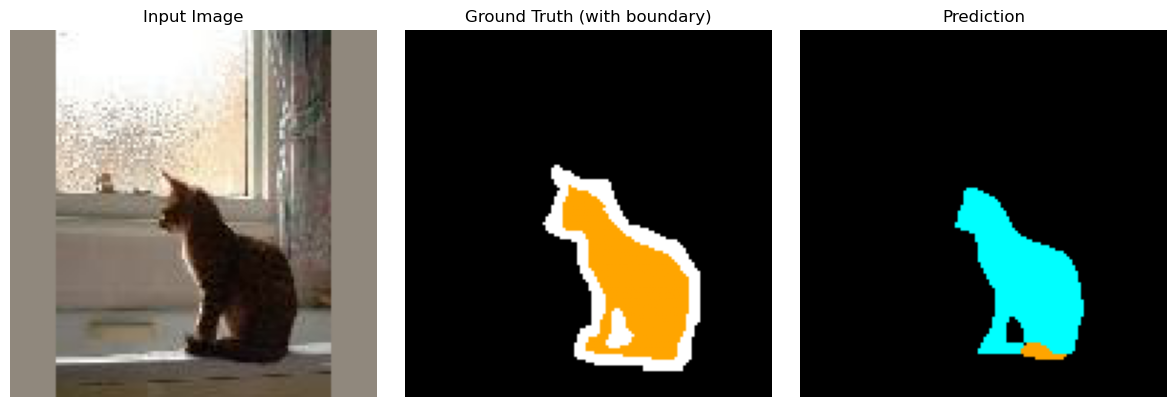

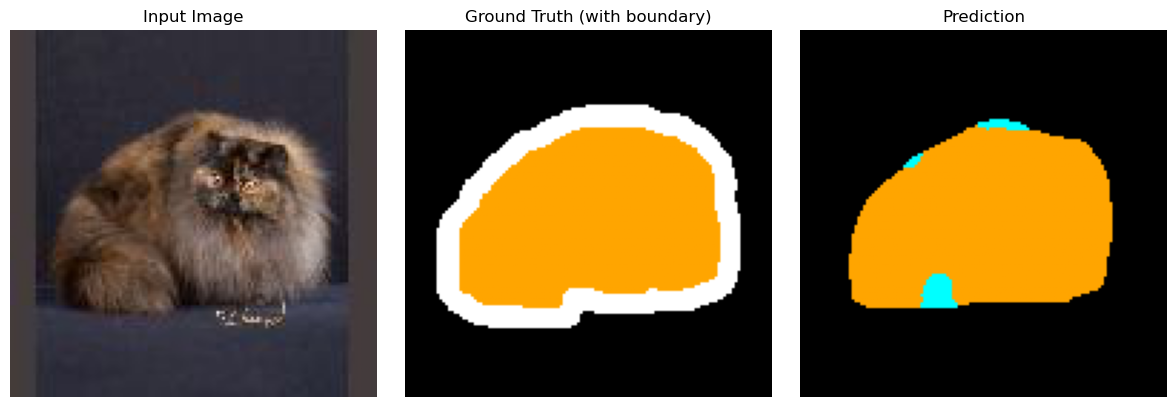

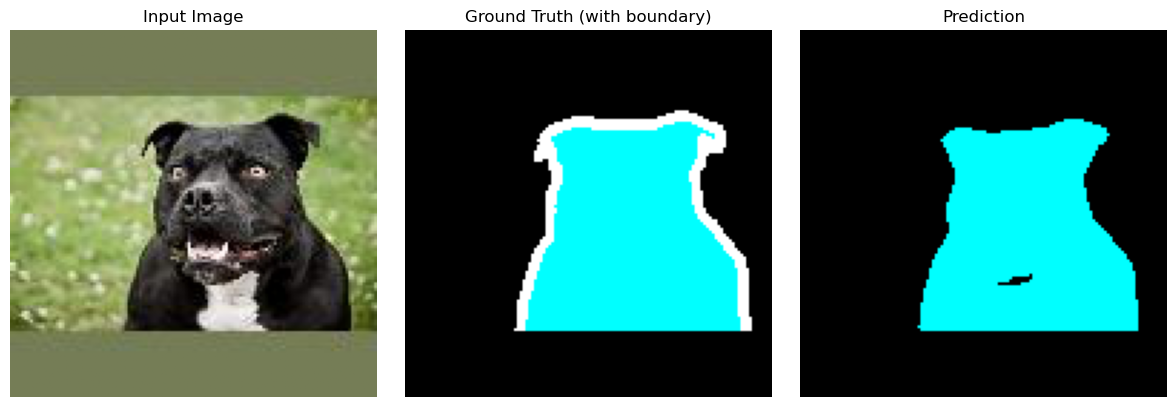

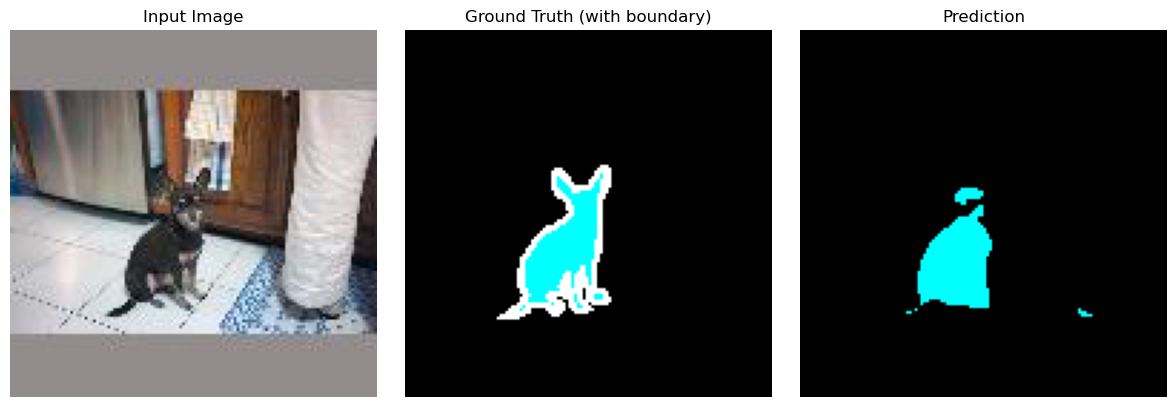

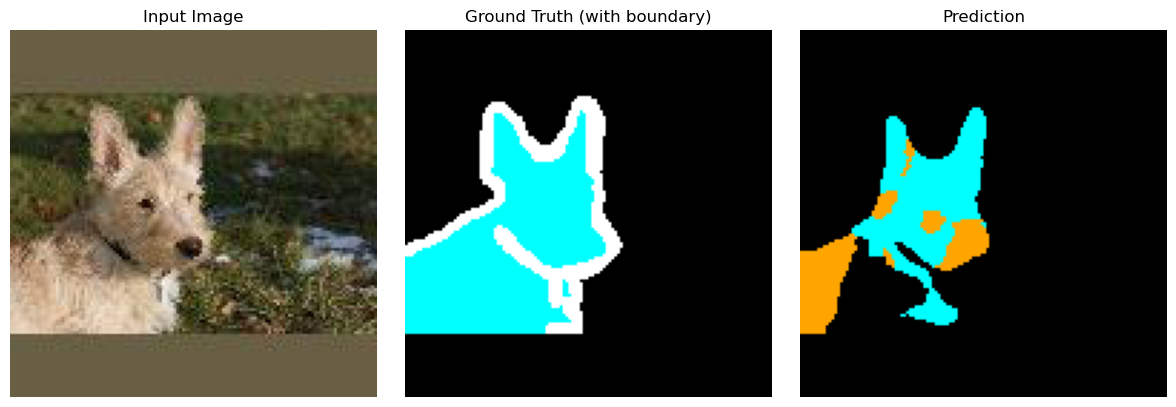

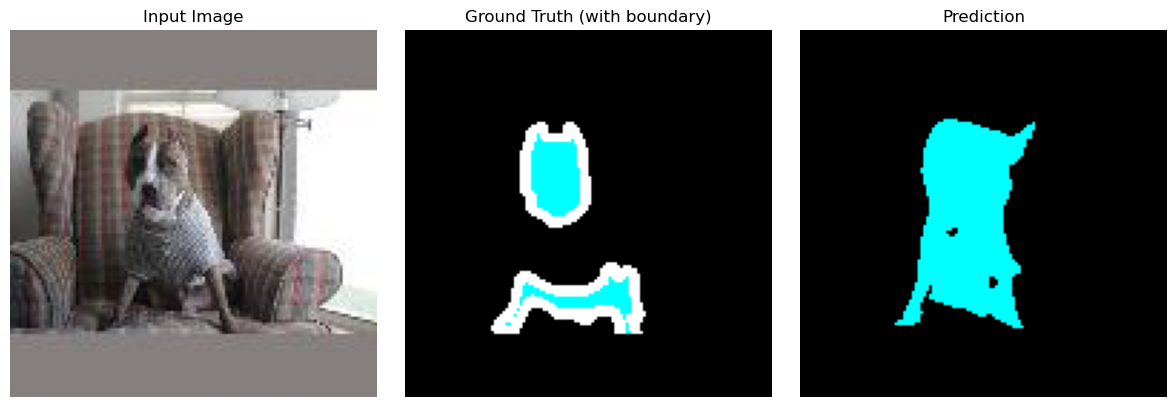

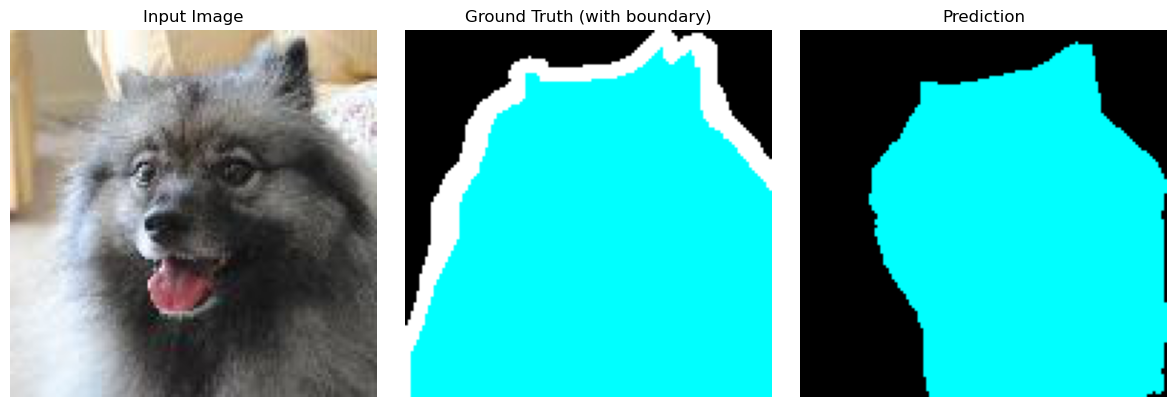

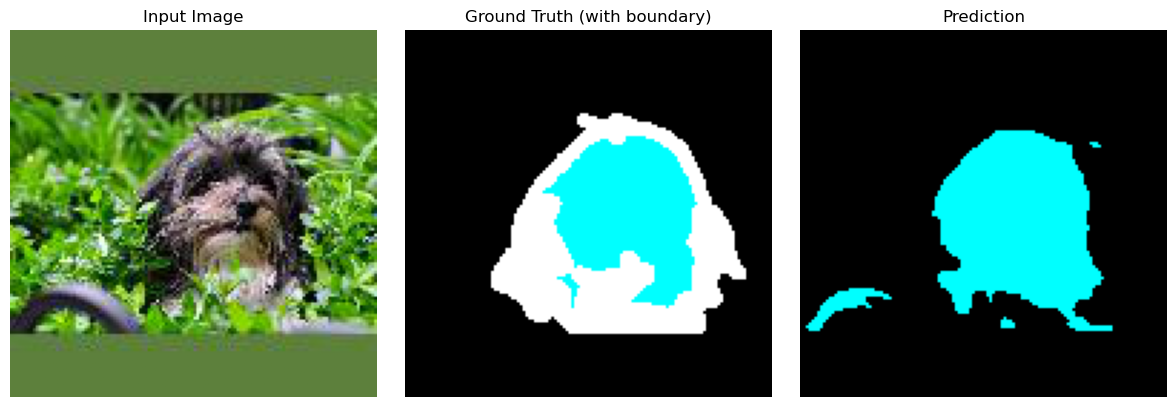

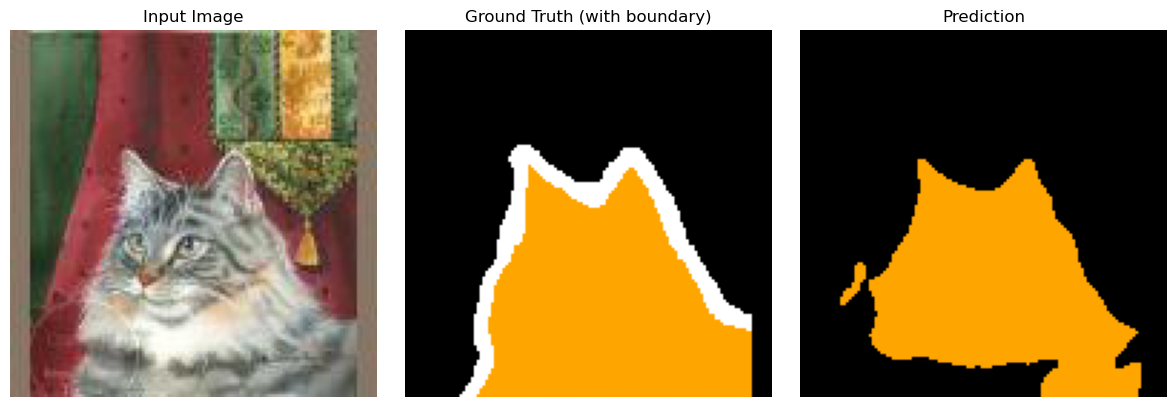

In [21]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os

# Add these imports
from matplotlib.colors import ListedColormap

# Helper: compute metrics ignoring boundary pixels (assumed to be labeled as 255)
def compute_metrics_valid(all_preds, all_targets, num_classes=3, smooth=1e-6):
    """
    all_preds, all_targets: 1D tensors of predictions and ground truths (valid pixels only)
    Returns:
      - iou_per_class: a tensor of IoU values for each class (0,1,2)
      - mean_iou: average IoU (ignoring NaNs)
      - dice_per_class: a tensor of Dice scores for each class
      - mean_dice: average Dice score (ignoring NaNs)
    """
    iou_list = []
    dice_list = []
    for cls in range(num_classes):
        pred_inds = (all_preds == cls)
        target_inds = (all_targets == cls)
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()
        if union == 0:
            iou_cls = float('nan')
        else:
            iou_cls = (intersection + smooth) / (union + smooth)
        iou_list.append(iou_cls)
        
        # Dice coefficient:
        dice_cls = (2 * intersection + smooth) / (pred_inds.sum() + target_inds.sum() + smooth)
        dice_list.append(dice_cls)
    
    iou_tensor = torch.tensor(iou_list, dtype=torch.float32)
    mean_iou = torch.nanmean(iou_tensor).item()
    dice_tensor = torch.tensor(dice_list, dtype=torch.float32)
    mean_dice = torch.nanmean(dice_tensor).item()
    return iou_tensor, mean_iou, dice_tensor, mean_dice

def test_model(model_path, test_dataset, batch_size=8):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    
    # Instantiate and load the model (make sure UNet is defined or imported)
    model = UNet(n_channels=3, n_classes=3).to(device)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    
    # Use ignore_index=255 so that boundary pixels are not considered in loss
    criterion = torch.nn.CrossEntropyLoss(ignore_index=255)
    
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    total_loss = 0.0
    total_pixels = 0
    correct_pixels = 0
    
    valid_preds_list = []
    valid_targets_list = []
    
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.to(device)
            
            outputs = model(images)  # raw logits, shape: (N, 3, H, W)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * images.size(0)
            
            preds = torch.argmax(outputs, dim=1)  # shape: (N, H, W)
            
            # Create valid mask: ignore boundary pixels (assumed to be labeled as 255)
            valid_mask = (targets != 255)
            total_pixels += valid_mask.sum().item()
            correct_pixels += ((preds == targets) & valid_mask).sum().item()
            
            # For metrics (IoU, Dice) accumulate valid pixels per sample
            for i in range(images.size(0)):
                pred_sample = preds[i]
                target_sample = targets[i]
                valid = (target_sample != 255)
                if valid.sum() > 0:
                    valid_preds_list.append(pred_sample[valid])
                    valid_targets_list.append(target_sample[valid])
    
    avg_loss = total_loss / len(test_dataset)
    pixel_acc = correct_pixels / total_pixels if total_pixels > 0 else 0.0
    
    # Concatenate all valid pixels across the dataset
    all_preds_valid = torch.cat(valid_preds_list)
    all_targets_valid = torch.cat(valid_targets_list)
    
    # Compute IoU and Dice on valid pixels (for classes 0,1,2)
    iou_tensor, mean_iou, dice_tensor, mean_dice = compute_metrics_valid(
        all_preds_valid, all_targets_valid, num_classes=3
    )
    
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Pixel Accuracy (ignoring boundary): {pixel_acc:.4f}")
    print(f"Test IoU per class: {iou_tensor.numpy()}, Average IoU: {mean_iou:.4f}")
    print(f"Test Dice per class: {dice_tensor.numpy()}, Average Dice: {mean_dice:.4f}")
    
    return avg_loss, pixel_acc, mean_iou, iou_tensor, mean_dice, model

# Example of visualization of one sample with proper colormaps:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image

def visualize_sample(dataset, model, device, idx, image_paths, mask_dir):
    """
    Visualize a single sample using the color-coded mask on disk:
      - background=0 (black)
      - cat=1 (orange)
      - dog=2 (cyan)
      - boundary=3 (white)

    Arguments:
      dataset     : your PatchBasedDataset
      model       : the trained UNet
      device      : torch.device
      idx         : index of the sample to visualize
      image_paths : list of original image-file paths
      mask_dir    : directory containing the color-coded mask .png files
    """
    # --- 1) Define colormaps:
    cmap_gt = ListedColormap(['black', 'orange', 'cyan', 'white'])  # 4 labels
    cmap_pred = ListedColormap(['black', 'orange', 'cyan'])         # 3 labels

    # --- 2) Get the input image from the PatchBasedDataset
    #         (We won't use the single-channel mask here for visualization.)
    img, _ = dataset[idx]

    # --- 3) Use the external image_paths list to find the mask
    image_path = image_paths[idx]  # e.g. "./Dataset/processed/Test/images/img001.jpg"
    mask_path = os.path.join(mask_dir, Path(image_path).stem + ".png")
    
    # Load the color-coded mask
    mask_img = Image.open(mask_path).convert("RGB")
    mask_np = np.array(mask_img, dtype=np.uint8)

    # --- 4) Convert the RGB mask to 4 labels: 0=bg,1=cat,2=dog,3=boundary
    gt_vis = np.zeros(mask_np.shape[:2], dtype=np.int64)

    # background = black
    background_mask = (
        (mask_np[..., 0] == 0) &
        (mask_np[..., 1] == 0) &
        (mask_np[..., 2] == 0)
    )
    # cat = orange (255,165,0)
    cat_mask = (
        (mask_np[..., 0] == 255) &
        (mask_np[..., 1] == 165) &
        (mask_np[..., 2] == 0)
    )
    # dog = cyan (0,255,255)
    dog_mask = (
        (mask_np[..., 0] == 0) &
        (mask_np[..., 1] == 255) &
        (mask_np[..., 2] == 255)
    )
    # boundary = everything else
    boundary_mask = ~(background_mask | cat_mask | dog_mask)

    gt_vis[background_mask] = 0
    gt_vis[cat_mask]        = 1
    gt_vis[dog_mask]        = 2
    gt_vis[boundary_mask]   = 3

    # --- 5) Run the UNet to get a prediction
    model.eval()
    img_tensor = img.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # --- 6) Convert the input image to NumPy for plotting
    img_np = img.permute(1, 2, 0).cpu().numpy()

    # --- 7) Plot the results
    plt.figure(figsize=(12, 4))

    # Input
    plt.subplot(1, 3, 1)
    plt.imshow(img_np)
    plt.title("Input Image")
    plt.axis("off")

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(gt_vis, cmap=cmap_gt, vmin=-0.5, vmax=3.5)
    plt.title("Ground Truth (with boundary)")
    plt.axis("off")

    # Prediction
    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap=cmap_pred, vmin=-0.5, vmax=2.5)
    plt.title("Prediction")
    plt.axis("off")

    plt.tight_layout()
    plt.savefig(f"Unet_Test_{idx}.pdf", bbox_inches="tight")
    plt.show()

# --- Main block for testing ---
if __name__ == "__main__":
    from torch.utils.data import DataLoader
    from torchvision import transforms

    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using {device} device")

    transform_img = transforms.Compose([
        transforms.ToTensor(),
    ])
    transform_label = None  # Assuming your dataset returns long tensors for labels

    # Example: PatchBasedDataset or any other dataset you use
    test_dataset = PatchBasedDataset(
        root_dir="./Dataset/processed/Test",
        patch_size=128,
        transform_img=transform_img,
        transform_label=transform_label
    )

    # Run the test function
    avg_loss, pixel_acc, mean_iou, iou_tensor, mean_dice, model = test_model(
        "unet_best.pth", test_dataset, batch_size=8
    )

    # Visualize some random samples (either full image or patch)
    import random
    random_indices = random.sample(range(len(test_dataset)), 10)
    for idx in random_indices:
        visualize_sample(
            dataset=test_dataset,
            model=model,
            device=device,
            idx=idx,
            image_paths=test_image_paths,
            mask_dir=test_mask_dir
        )

Using mps device


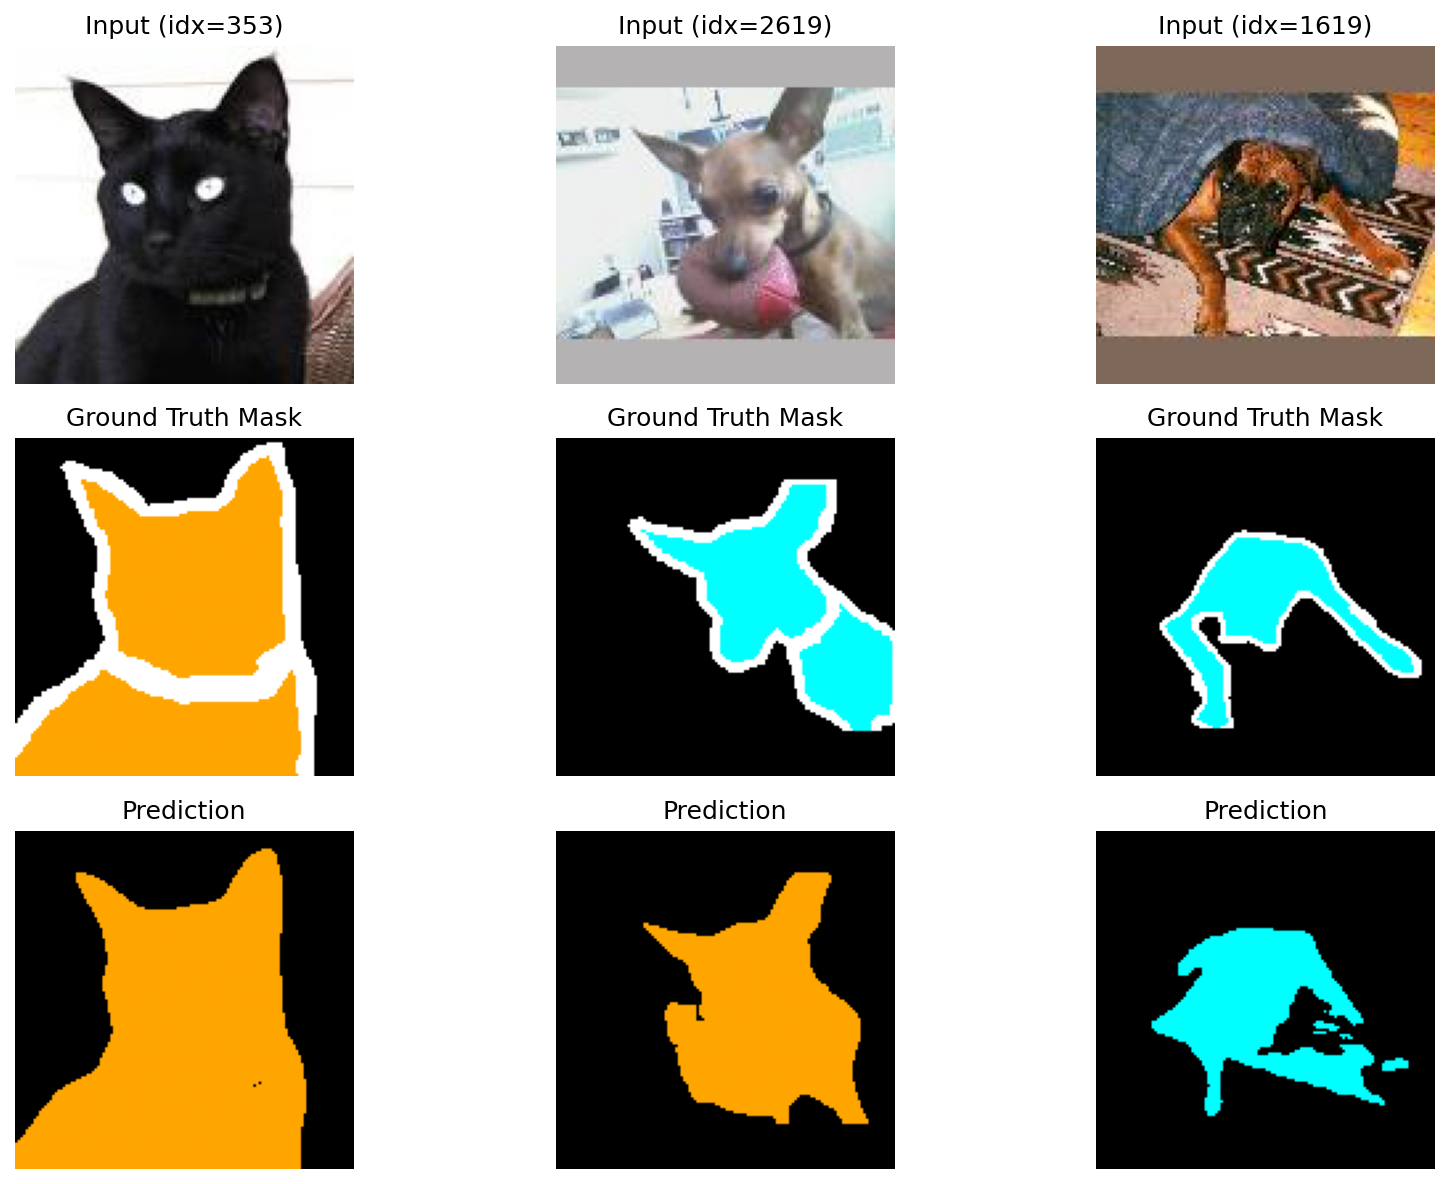

In [ ]:
import matplotlib.pyplot as plt
import torch

import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
from pathlib import Path

def visualize_three_samples_color(dataset, model, device, 
                                  indices=[353, 2619, 1619], 
                                  image_paths=None, 
                                  mask_dir=None):
    """
    Make a single figure of shape (3 rows x 3 columns), for the given 'indices':
      Row 0: Input images
      Row 1: Ground truth (with boundary)
      Row 2: Predictions
    Columns correspond to the provided indices.

    Uses the color-coded mask from disk:
      - background=0 (black)
      - cat=1 (orange)
      - dog=2 (cyan)
      - boundary=3 (white)
    """

    # --- 1) Define colormaps
    cmap_gt   = ListedColormap(['black', 'orange', 'cyan', 'white'])  # 4 labels
    cmap_pred = ListedColormap(['black', 'orange', 'cyan'])           # 3 labels

    # Create the figure and axes array: 3 rows x len(indices) columns
    fig, axes = plt.subplots(nrows=3, ncols=len(indices), figsize=(12, 8))

    plt.subplots_adjust(wspace=0.01, hspace=0.01)

    model.eval()
    for col, idx in enumerate(indices):
        # 2) Load the sample from the dataset
        img, _ = dataset[idx]  # we ignore the single-channel mask from the dataset

        # 3) Re-load the color-coded mask from disk
        image_path = image_paths[idx]  # e.g. "./Test/images/img0001.jpg"
        mask_path  = os.path.join(mask_dir, Path(image_path).stem + ".png")
        mask_img   = Image.open(mask_path).convert("RGB")
        mask_np    = np.array(mask_img, dtype=np.uint8)

        # 4) Convert the RGB mask to 4 labels: 0=bg,1=cat,2=dog,3=boundary
        gt_vis = np.zeros(mask_np.shape[:2], dtype=np.int64)

        # background = black
        background_mask = (
            (mask_np[..., 0] == 0) & 
            (mask_np[..., 1] == 0) & 
            (mask_np[..., 2] == 0)
        )
        # cat = orange (255,165,0)
        cat_mask = (
            (mask_np[..., 0] == 255) &
            (mask_np[..., 1] == 165) &
            (mask_np[..., 2] == 0)
        )
        # dog = cyan (0,255,255)
        dog_mask = (
            (mask_np[..., 0] == 0) &
            (mask_np[..., 1] == 255) &
            (mask_np[..., 2] == 255)
        )
        # boundary = everything else
        boundary_mask = ~(background_mask | cat_mask | dog_mask)

        gt_vis[background_mask] = 0
        gt_vis[cat_mask]        = 1
        gt_vis[dog_mask]        = 2
        gt_vis[boundary_mask]   = 3

        # 5) Run the UNet model to get a prediction
        img_tensor = img.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(img_tensor)
            pred   = output.argmax(dim=1).squeeze(0).cpu().numpy()

        # 6) Convert the input image to NumPy
        img_np = img.permute(1, 2, 0).cpu().numpy()

        # 7) Plot: row 0 = input, row 1 = ground truth, row 2 = prediction
        # Input
        axes[0, col].imshow(img_np)
        axes[0, col].set_title(f"Input (idx={idx})")
        axes[0, col].axis("off")

        # Ground Truth (with boundary)
        axes[1, col].imshow(gt_vis, cmap=cmap_gt, vmin=-0.5, vmax=3.5)
        axes[1, col].set_title("Ground Truth Mask")
        axes[1, col].axis("off")

        # Prediction
        axes[2, col].imshow(pred, cmap=cmap_pred, vmin=-0.5, vmax=2.5)
        axes[2, col].set_title("Prediction")
        axes[2, col].axis("off")

    plt.tight_layout()
    plt.savefig("UNet_prediction_examples.pdf", bbox_inches="tight")
    plt.show()

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")

transform_img = transforms.Compose([
        transforms.ToTensor(),
    ])
transform_label = None  

test_dataset = PatchBasedDataset(
    root_dir="./Dataset/processed/Test",
    patch_size=128,
    transform_img=transform_img,
    transform_label=transform_label
)

indices_to_plot = [353, 2619, 1619]
visualize_three_samples_color(
    dataset=test_dataset,
    model=model,
    device=device,
    indices=indices_to_plot,
    image_paths=test_image_paths,
    mask_dir=test_mask_dir
)

In [39]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
from pathlib import Path

def visualize_samples_separately(dataset, model, device, 
                                 indices=[353, 2619, 1619], 
                                 image_paths=None, 
                                 mask_dir=None,
                                 save_prefix="UNet_prediction_example"):
    """
    For each index in 'indices', create a figure with 3 rows:
      - Row 0: Input image
      - Row 1: Ground Truth (with boundary)
      - Row 2: Prediction
    Save each figure separately as a PDF file.
    
    Assumes that:
      - image_paths is a list of original image file paths
      - mask_dir is the directory containing the color-coded mask .png files
    """
    # Define colormaps.
    cmap_gt   = ListedColormap(['black', 'orange', 'cyan', 'white'])  # 4 labels: bg, cat, dog, boundary
    cmap_pred = ListedColormap(['black', 'orange', 'cyan'])           # 3 labels: bg, cat, dog

    model.eval()
    for idx in indices:
        # Load the sample from the dataset.
        img, _ = dataset[idx]  # ignoring the dataset mask (we re-load the color-coded version)

        # Re-load the original color-coded mask from disk.
        image_path = image_paths[idx]  # e.g. "./Test/images/img0001.jpg"
        mask_path  = os.path.join(mask_dir, Path(image_path).stem + ".png")
        mask_img   = Image.open(mask_path).convert("RGB")
        mask_np    = np.array(mask_img, dtype=np.uint8)

        # Convert the RGB mask to 4 labels: 0=background, 1=cat, 2=dog, 3=boundary.
        gt_vis = np.zeros(mask_np.shape[:2], dtype=np.int64)
        background_mask = ((mask_np[..., 0] == 0) & (mask_np[..., 1] == 0) & (mask_np[..., 2] == 0))
        cat_mask        = ((mask_np[..., 0] == 255) & (mask_np[..., 1] == 165) & (mask_np[..., 2] == 0))
        dog_mask        = ((mask_np[..., 0] == 0) & (mask_np[..., 1] == 255) & (mask_np[..., 2] == 255))
        boundary_mask   = ~(background_mask | cat_mask | dog_mask)

        gt_vis[background_mask] = 0
        gt_vis[cat_mask]        = 1
        gt_vis[dog_mask]        = 2
        gt_vis[boundary_mask]   = 3

        # Run the model to get a prediction.
        img_tensor = img.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(img_tensor)
            pred   = output.argmax(dim=1).squeeze(0).cpu().numpy()

        # Convert the input image tensor to a NumPy array for plotting.
        img_np = img.permute(1, 2, 0).cpu().numpy()

        # Create a new figure with 3 rows and 1 column.
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 12))
        plt.subplots_adjust(wspace=0.01, hspace=0.01)

        # Row 0: Input Image.
        axes[0].imshow(img_np)
        axes[0].set_title(f"Input (idx={idx})")
        axes[0].axis("off")

        # Row 1: Ground Truth Mask.
        axes[1].imshow(gt_vis, cmap=cmap_gt, vmin=-0.5, vmax=3.5)
        axes[1].set_title("Ground Truth Mask")
        axes[1].axis("off")

        # Row 2: Prediction.
        axes[2].imshow(pred, cmap=cmap_pred, vmin=-0.5, vmax=2.5)
        axes[2].set_title("Prediction")
        axes[2].axis("off")

        plt.tight_layout()

        # Save the figure to a separate PDF file.
        output_filename = f"{save_prefix}_{idx}.pdf"
        plt.savefig(output_filename, bbox_inches="tight")
        plt.close(fig)
        print(f"Saved {output_filename}")

# Example usage:
# Make sure 'test_dataset' is defined, and that 'test_image_paths' and 'test_mask_dir' are set.
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")

transform_img = transforms.Compose([
    transforms.ToTensor(),
])
transform_label = None  

test_dataset = PatchBasedDataset(
    root_dir="./Dataset/processed/Test",
    patch_size=128,
    transform_img=transform_img,
    transform_label=transform_label
)

indices_to_plot = [353, 2619, 1619]
visualize_samples_separately(
    dataset=test_dataset,
    model=model,
    device=device,
    indices=indices_to_plot,
    image_paths=test_image_paths,
    mask_dir=test_mask_dir
)

Using mps device
Saved UNet_prediction_example_353.pdf
Saved UNet_prediction_example_2619.pdf
Saved UNet_prediction_example_1619.pdf


In [42]:
import fitz  # PyMuPDF
from PIL import Image

def merge_pdfs_to_single_page(pdf_list, output_path, dpi=150):
    """
    Render each first page of the PDFs as an image, then stitch them vertically
    into one image, and save as a single-page PDF.

    Arguments:
      pdf_list: list of PDF file paths.
      output_path: path to save the merged PDF.
      dpi: resolution for rendering.
    """
    images = []
    for pdf in pdf_list:
        doc = fitz.open(pdf)
        page = doc.load_page(0)
        # Compute zoom factor from default 72 dpi to desired dpi.
        zoom = dpi / 72.0
        mat = fitz.Matrix(zoom, zoom)
        pix = page.get_pixmap(matrix=mat)
        # Convert pixmap to a PIL Image (RGB)
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        images.append(img)
        doc.close()
    
    # Calculate the maximum width and total height for vertical stacking.
    widths, heights = zip(*(im.size for im in images))
    max_width = max(widths)
    total_height = sum(heights)
    
    # Create a new blank image with white background.
    merged_img = Image.new('RGB', (max_width, total_height), color=(255, 255, 255))
    
    # Paste each image one below the other.
    y_offset = 0
    for im in images:
        merged_img.paste(im, (0, y_offset))
        y_offset += im.height

    # Save the merged image as a PDF.
    merged_img.save(output_path, "PDF", resolution=dpi)
    print(f"Merged PDF saved as {output_path}")

if __name__ == '__main__':
    pdf_files = ['UNet_prediction_example_353.pdf', 'UNet_prediction_example_2619.pdf', 'UNet_prediction_example_1619.pdf']
    output_pdf = 'UNet_prediction_examples.pdf'
    merge_pdfs_to_single_page(pdf_files, output_pdf, dpi=150)

Merged PDF saved as UNet_prediction_examples.pdf
